Batch Processing Pipeline - Used car market analysis

🛠️ Windows Hadoop/Spark Setup
What this does: This script automates the installation of Hadoop binaries on Windows. It creates the directory C:\hadoop\bin, downloads the required winutils.exe and hadoop.dll files, and sets the HADOOP_HOME environment variable.

Why it is needed: Apache Spark is designed for Linux/Unix systems. On Windows, it fails to perform file operations (like saving data or creating temporary buffers for BigQuery) because it cannot check file permissions natively. winutils.exe acts as a bridge, simulating the necessary Linux file system permissions so Spark can run without crashing.

In [2]:
import os
import urllib.request
import sys

def setup_windows_hadoop():
    # 1. Define Paths
    # We use C:/hadoop because it avoids space-in-path issues (like "Program Files")
    base_dir = "C:\\hadoop"
    bin_dir = os.path.join(base_dir, "bin")

    # 2. Create Directories
    print(f"📂 Creating directory structure: {bin_dir}...")
    try:
        os.makedirs(bin_dir, exist_ok=True)
        print("   Directory created (or already exists).")
    except PermissionError:
        print("❌ ERROR: Permission denied. Try running PyCharm/Jupyter as Administrator.")
        return False

    # 3. Define Files to Download (Standard Hadoop 3.2.2 binaries for Spark 3.x)
    # Source: cdarlint/winutils (The standard community source)
    base_url = "https://github.com/cdarlint/winutils/raw/master/hadoop-3.2.2/bin/"
    files = ["winutils.exe", "hadoop.dll"]

    # 4. Download Files
    print("\n⬇️ Downloading required binaries...")
    for filename in files:
        target_path = os.path.join(bin_dir, filename)
        url = base_url + filename

        if os.path.exists(target_path):
            print(f"   ✅ {filename} already exists. Skipping.")
        else:
            print(f"   ⏳ Downloading {filename}...")
            try:
                urllib.request.urlretrieve(url, target_path)
                print(f"   ✅ Downloaded {filename}")
            except Exception as e:
                print(f"   ❌ Failed to download {filename}: {e}")
                return False

    # 5. Set Environment Variables for THIS session
    print("\n🔧 Configuring Environment Variables...")
    os.environ['HADOOP_HOME'] = base_dir
    # Add bin to PATH if not there
    if bin_dir not in os.environ['PATH']:
        os.environ['PATH'] = bin_dir + ";" + os.environ['PATH']

    print("✅ SUCCESS: Hadoop environment is set up.")
    print(f"   HADOOP_HOME = {os.environ['HADOOP_HOME']}")
    return True

# Execute
if sys.platform.startswith('win'):
    setup_windows_hadoop()
else:
    print("Skipping Windows setup (Not running on Windows).")

📂 Creating directory structure: C:\hadoop\bin...
   Directory created (or already exists).

⬇️ Downloading required binaries...
   ⏳ Downloading winutils.exe...
   ✅ Downloaded winutils.exe
   ⏳ Downloading hadoop.dll...
   ✅ Downloaded hadoop.dll

🔧 Configuring Environment Variables...
✅ SUCCESS: Hadoop environment is set up.
   HADOOP_HOME = C:\hadoop


Pipeline continues here

In [1]:
import sys
import os
import shutil
import time
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.functions import (
    col, count, mean, stddev, desc, upper, lower,
    current_timestamp, to_date, when, round, lit, substring, abs as spark_abs
)
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

# ==========================================
# 1. CONTROL PANEL
# ==========================================
IS_LOCAL = True

# TOGGLE THIS: True = 1.5GB file, False = 100 row file
USE_FULL_DATASET = True

# --- GOOGLE CLOUD CONFIG ---
GCP_PROJECT_ID = "your-project-id"
BQ_DATASET_NAME = "vehicles_data"
BQ_TABLE_NAME = "market_intelligence_system"
GCS_TEMP_BUCKET = "your-staging-bucket"

# ==========================================
# 2. NETWORK & PATH CONFIGURATION
# ==========================================
# Force Spark to bind to localhost (Fixes ConnectionRefusedError)
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"

# Cleanup Lock Files from previous crashes
print("🧹 Cleaning up lock files...")
for path in ["metastore_db", "derby.log", "spark-warehouse"]:
    if os.path.exists(path):
        try:
            if os.path.isdir(path): shutil.rmtree(path)
            else: os.remove(path)
        except: pass

if IS_LOCAL:
    print("🔧 Configuring for WINDOWS LOCALHOST...")

    # Force Paths
    os.environ['PYSPARK_PYTHON'] = sys.executable
    os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
    os.environ['HADOOP_HOME'] = "C:/hadoop"
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "C:/Users/vanac/keys/my-service-account.json"

    # Define Input Paths
    PATH_SMALL = "C:/Users/vanac/Downloads/first100_vehicles.csv"
    PATH_FULL  = "C:/Users/vanac/Downloads/vehicles.csv"
else:
    print("☁️ Configuring for CLOUD/VM Environment...")
    PATH_SMALL = "gs://your-bucket/input/first100_vehicles.csv"
    PATH_FULL  = "gs://your-bucket/input/vehicles.csv"

# SELECT THE FILE BASED ON YOUR TOGGLE
INPUT_FILE = PATH_FULL if USE_FULL_DATASET else PATH_SMALL

# ==========================================
# 3. INITIALIZE SPARK
# ==========================================
conf = SparkConf()
conf.setAppName("Advanced_Market_Pipeline")
conf.set("spark.driver.memory", "2g")
conf.set("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.34.0")

if IS_LOCAL:
    conf.setMaster("local[*]")

    # NETWORK FIXES (Crucial for Windows)
    conf.set("spark.driver.bindAddress", "127.0.0.1")
    conf.set("spark.driver.host", "127.0.0.1")

    # TEMP WAREHOUSE FIX
    os.makedirs("C:/temp/spark_warehouse", exist_ok=True)
    conf.set("spark.sql.warehouse.dir", "file:///C:/temp/spark_warehouse")

print("🚀 Starting Spark Engine...")

try:
    spark = SparkSession.builder.config(conf=conf).getOrCreate()
    spark.sparkContext.setLogLevel("WARN")
    print(f"✅ SUCCESS: Spark is running.")
    print(f"📂 Target File: {INPUT_FILE} (Full Dataset: {USE_FULL_DATASET})")

except Exception as e:
    print("\n❌ FAILED TO START")
    print(e)

🧹 Cleaning up lock files...
🔧 Configuring for WINDOWS LOCALHOST...
🚀 Starting Spark Engine...
✅ SUCCESS: Spark is running.
📂 Target File: C:/Users/vanac/Downloads/vehicles.csv (Full Dataset: True)


In [2]:
print("--- Step 1: Ingestion ---")
# Load raw data
df_raw = spark.read.csv(INPUT_FILE, header=True, inferSchema=True)
print(f"Raw Count: {df_raw.count()}")

--- Step 1: Ingestion ---
Raw Count: 441802


In [3]:
print("--- Step 2: Preprocessing & Standardization ---")

# 1. Standardize Strings (Remove whitespace, uppercase)
df_prep = df_raw \
    .withColumn("manufacturer", upper(col("manufacturer"))) \
    .withColumn("model", upper(col("model"))) \
    .withColumn("title_status", lower(col("title_status"))) \
    .withColumn("vin", upper(col("VIN"))) # Standardize VIN column name

# 2. Handle Nulls (Based on Assumptions)
df_clean = df_prep \
    .dropna(subset=["manufacturer", "model", "year", "price"]) \
    .filter(col("price") > 500) \
    .filter(col("price") < 200000) \
    .fillna({"odometer": -1, "title_status": "clean"}) # Assumption: Missing title = clean

# 3. Type Casting
df_clean = df_clean \
    .withColumn("year", col("year").cast(IntegerType())) \
    .withColumn("odometer", col("odometer").cast(DoubleType()))

print(f"Cleaned Count: {df_clean.count()}")
df_clean.select("manufacturer", "model", "year", "price", "odometer", "title_status").show(5)

--- Step 2: Preprocessing & Standardization ---
Cleaned Count: 364062
+------------+--------------------+----+-----+--------+------------+
|manufacturer|               model|year|price|odometer|title_status|
+------------+--------------------+----+-----+--------+------------+
|         GMC|SIERRA 1500 CREW ...|2014|33590| 57923.0|       clean|
|   CHEVROLET|      SILVERADO 1500|2010|22590| 71229.0|       clean|
|   CHEVROLET| SILVERADO 1500 CREW|2020|39590| 19160.0|       clean|
|      TOYOTA|TUNDRA DOUBLE CAB SR|2017|30990| 41124.0|       clean|
|        FORD|           F-150 XLT|2013|15000|128000.0|       clean|
+------------+--------------------+----+-----+--------+------------+
only showing top 5 rows



In [4]:
print("--- Step 2: Statistical Scoring ---")

# 1. Define the Window
# "Group by Manufacturer, Model, and Year"
windowSpec = Window.partitionBy("manufacturer", "model", "year")

# 2. Calculate Group Statistics (Average & StdDev)
df_stats = df_clean \
    .withColumn("market_avg_price", round(mean("price").over(windowSpec), 2)) \
    .withColumn("market_std_dev", round(stddev("price").over(windowSpec), 2)) \
    .withColumn("group_count", count("id").over(windowSpec))

# 3. Calculate Z-Score
# Formula: (Price - Average) / Standard Deviation
# Logic: How far is this specific car from the 'normal' price?
df_scored = df_stats.withColumn("price_z_score",
    (col("price") - col("market_avg_price")) / when(col("market_std_dev") == 0, 1).otherwise(col("market_std_dev"))
)

# 4. Assign Ratings
df_scored_labeled = df_scored.withColumn("deal_rating",
    when(col("group_count") < 5, "INSUFFICIENT_DATA")  # Skip rare cars
    .when(col("price_z_score") < -1.5, "GREAT DEAL")   # Cheap
    .when(col("price_z_score").between(-1.5, -0.5), "GOOD PRICE")
    .when(col("price_z_score").between(-0.5, 0.5), "FAIR MARKET")
    .when(col("price_z_score") > 1.5, "OVERPRICED")    # Expensive
    .otherwise("SLIGHTLY HIGH")
)

print("Scoring Complete. Preview:")
df_scored_labeled.select("manufacturer", "model", "price", "market_avg_price", "deal_rating").show(10)

--- Step 2: Statistical Scoring ---
Scoring Complete. Preview:
+------------+--------------------+-----+----------------+-----------------+
|manufacturer|               model|price|market_avg_price|      deal_rating|
+------------+--------------------+-----+----------------+-----------------+
|       ACURA|               3.2TL| 4500|          4500.0|INSUFFICIENT_DATA|
|       ACURA|               3.2TL| 3995|          3995.0|INSUFFICIENT_DATA|
|       ACURA|               3.5RL| 5200|          5200.0|INSUFFICIENT_DATA|
|       ACURA|ILX PREMIUM AND A...|28590|         28290.0|      FAIR MARKET|
|       ACURA|ILX PREMIUM AND A...|28590|         28290.0|      FAIR MARKET|
|       ACURA|ILX PREMIUM AND A...|28590|         28290.0|      FAIR MARKET|
|       ACURA|ILX PREMIUM AND A...|28590|         28290.0|      FAIR MARKET|
|       ACURA|ILX PREMIUM AND A...|28590|         28290.0|      FAIR MARKET|
|       ACURA|ILX PREMIUM AND A...|28590|         28290.0|      FAIR MARKET|
|       ACURA

In [5]:
print("--- Step 3: VIN Forensics & Fraud Detection ---")

# 1. VIN Year Logic (Simplified for 2010-2029 codes)
# Position 10 in VIN indicates year.
# A=2010, B=2011 ... H=2017, J=2018, K=2019, L=2020, M=2021, N=2022, P=2023
df_fraud_check = df_clean.withColumn("vin_year_code", substring(col("vin"), 10, 1))

# Map code to year (SQL-style Case Statement)
df_fraud_check = df_fraud_check.withColumn("decoded_vin_year",
    when(col("vin_year_code") == "A", 2010)
    .when(col("vin_year_code") == "B", 2011)
    .when(col("vin_year_code") == "C", 2012)
    .when(col("vin_year_code") == "D", 2013)
    .when(col("vin_year_code") == "E", 2014)
    .when(col("vin_year_code") == "F", 2015)
    .when(col("vin_year_code") == "G", 2016)
    .when(col("vin_year_code") == "H", 2017)
    .when(col("vin_year_code") == "J", 2018)
    .when(col("vin_year_code") == "K", 2019)
    .when(col("vin_year_code") == "L", 2020)
    .when(col("vin_year_code") == "M", 2021)
    .otherwise(0) # 0 means older than 2010 or not mapped
)

# 2. Fraud Logic
# Flag 1: Year Mismatch (VIN says 2012, Listing says 2018)
# Flag 2: Suspicious Low Mileage (Age > 5 years but odometer < 2000 miles)
current_yr = 2025
df_fraud_check = df_fraud_check \
    .withColumn("is_year_mismatch",
        when((col("decoded_vin_year") > 0) & (spark_abs(col("decoded_vin_year") - col("year")) > 1), True)
        .otherwise(False)
    ) \
    .withColumn("is_suspicious_mileage",
        when((col("year") < (current_yr - 5)) & (col("odometer") > 0) & (col("odometer") < 2000), True)
        .otherwise(False)
    )

# Trust Score (0 to 100)
# Start at 100. Subtract 50 for Year Mismatch. Subtract 30 for Suspicious Mileage.
df_fraud_check = df_fraud_check.withColumn("trust_score",
    lit(100) -
    when(col("is_year_mismatch"), 50).otherwise(0) -
    when(col("is_suspicious_mileage"), 30).otherwise(0)
)

print("Fraud Detection Preview (Low Trust Items):")
df_fraud_check.filter(col("trust_score") < 100).select("vin", "year", "decoded_vin_year", "odometer", "trust_score").show(5)

--- Step 3: VIN Forensics & Fraud Detection ---
Fraud Detection Preview (Low Trust Items):
+-----------------+----+----------------+--------+-----------+
|              vin|year|decoded_vin_year|odometer|trust_score|
+-----------------+----+----------------+--------+-----------+
|1FTER4EH3KLA31326|2019|            2019|  1834.0|         70|
|1C4GJXAGXKW566358|2019|            2019|  1423.0|         70|
|             null|1976|               0|   100.0|         70|
|             null|1979|               0|  1234.0|         70|
|1C4AJWAG1HL698869|2017|            2017|   891.0|         70|
+-----------------+----+----------------+--------+-----------+
only showing top 5 rows



In [6]:
print("--- Step 4: Geospatial Arbitrage ---")

# 1. Calculate National Average for every Make/Model/Year
national_window = Window.partitionBy("manufacturer", "model", "year")
df_geo = df_fraud_check.withColumn("national_avg_price", round(mean("price").over(national_window), 2))

# 2. Calculate Regional Arbitrage
# Arbitrage Value = National Average - Local Price
# Positive Value = Cheaper to buy here (Good for flipping)
# Negative Value = More expensive here (Bad for buying)
df_geo = df_geo.withColumn("arbitrage_opportunity", col("national_avg_price") - col("price"))

# 3. Flag High-Value Arbitrage Regions
# If you can save > $2000 by buying here vs national average, it's a "Sourcing Hub"
df_geo = df_geo.withColumn("is_sourcing_hub", when(col("arbitrage_opportunity") > 2000, True).otherwise(False))

print("Arbitrage Preview (Top Opportunities):")
df_geo.filter("is_sourcing_hub").select("region", "manufacturer", "model", "price", "national_avg_price", "arbitrage_opportunity").show(5)

--- Step 4: Geospatial Arbitrage ---
Arbitrage Preview (Top Opportunities):
+--------------------+------------+-----+-----+------------------+---------------------+
|              region|manufacturer|model|price|national_avg_price|arbitrage_opportunity|
+--------------------+------------+-----+-----+------------------+---------------------+
|            hartford|       ACURA|  MDX| 4600|           9421.46|    4821.459999999999|
|             orlando|       ACURA|  MDX| 4200|           9421.46|    5221.459999999999|
|              boston|       ACURA|  MDX| 7000|           9421.46|    2421.459999999999|
|western massachus...|       ACURA|  MDX| 6995|           9421.46|    2426.459999999999|
|       new york city|       ACURA|  MDX| 5600|           9421.46|    3821.459999999999|
+--------------------+------------+-----+-----+------------------+---------------------+
only showing top 5 rows



In [7]:
print("--- Step 5: Adjusted Deal Scoring ---")

windowSpec = Window.partitionBy("manufacturer", "model", "year")

df_scored = df_geo \
    .withColumn("market_std_dev", round(stddev("price").over(windowSpec), 2)) \
    .withColumn("group_count", count("id").over(windowSpec))

# Z-Score Calculation
df_scored = df_scored.withColumn("price_z_score",
    (col("price") - col("national_avg_price")) / when(col("market_std_dev") == 0, 1).otherwise(col("market_std_dev"))
)

# Rating Logic (Integrated with Fraud Check)
# If Trust Score is Low, it cannot be a "Great Deal" (It's a trap!)
df_final = df_scored.withColumn("deal_rating",
    when(col("trust_score") < 70, "RISKY_BUY") # New Category
    .when(col("group_count") < 5, "INSUFFICIENT_DATA")
    .when(col("price_z_score") < -1.5, "GREAT_DEAL")
    .when(col("price_z_score").between(-1.5, -0.5), "GOOD_PRICE")
    .when(col("price_z_score").between(-0.5, 0.5), "FAIR_MARKET")
    .otherwise("OVERPRICED")
)

print("Final Scored Data:")
df_final.select("manufacturer", "model", "price", "trust_score", "arbitrage_opportunity", "deal_rating").show(5)

--- Step 5: Adjusted Deal Scoring ---
Final Scored Data:
+------------+--------------------+-----+-----------+---------------------+-----------------+
|manufacturer|               model|price|trust_score|arbitrage_opportunity|      deal_rating|
+------------+--------------------+-----+-----------+---------------------+-----------------+
|       ACURA|               3.2TL| 4500|        100|                  0.0|INSUFFICIENT_DATA|
|       ACURA|               3.2TL| 3995|        100|                  0.0|INSUFFICIENT_DATA|
|       ACURA|               3.5RL| 5200|        100|                  0.0|INSUFFICIENT_DATA|
|       ACURA|ILX PREMIUM AND A...|28590|        100|               -300.0|      FAIR_MARKET|
|       ACURA|ILX PREMIUM AND A...|28590|        100|               -300.0|      FAIR_MARKET|
+------------+--------------------+-----+-----------+---------------------+-----------------+
only showing top 5 rows



📊 Generating Local Dashboard...
   Sampling 10% of data for visualization...


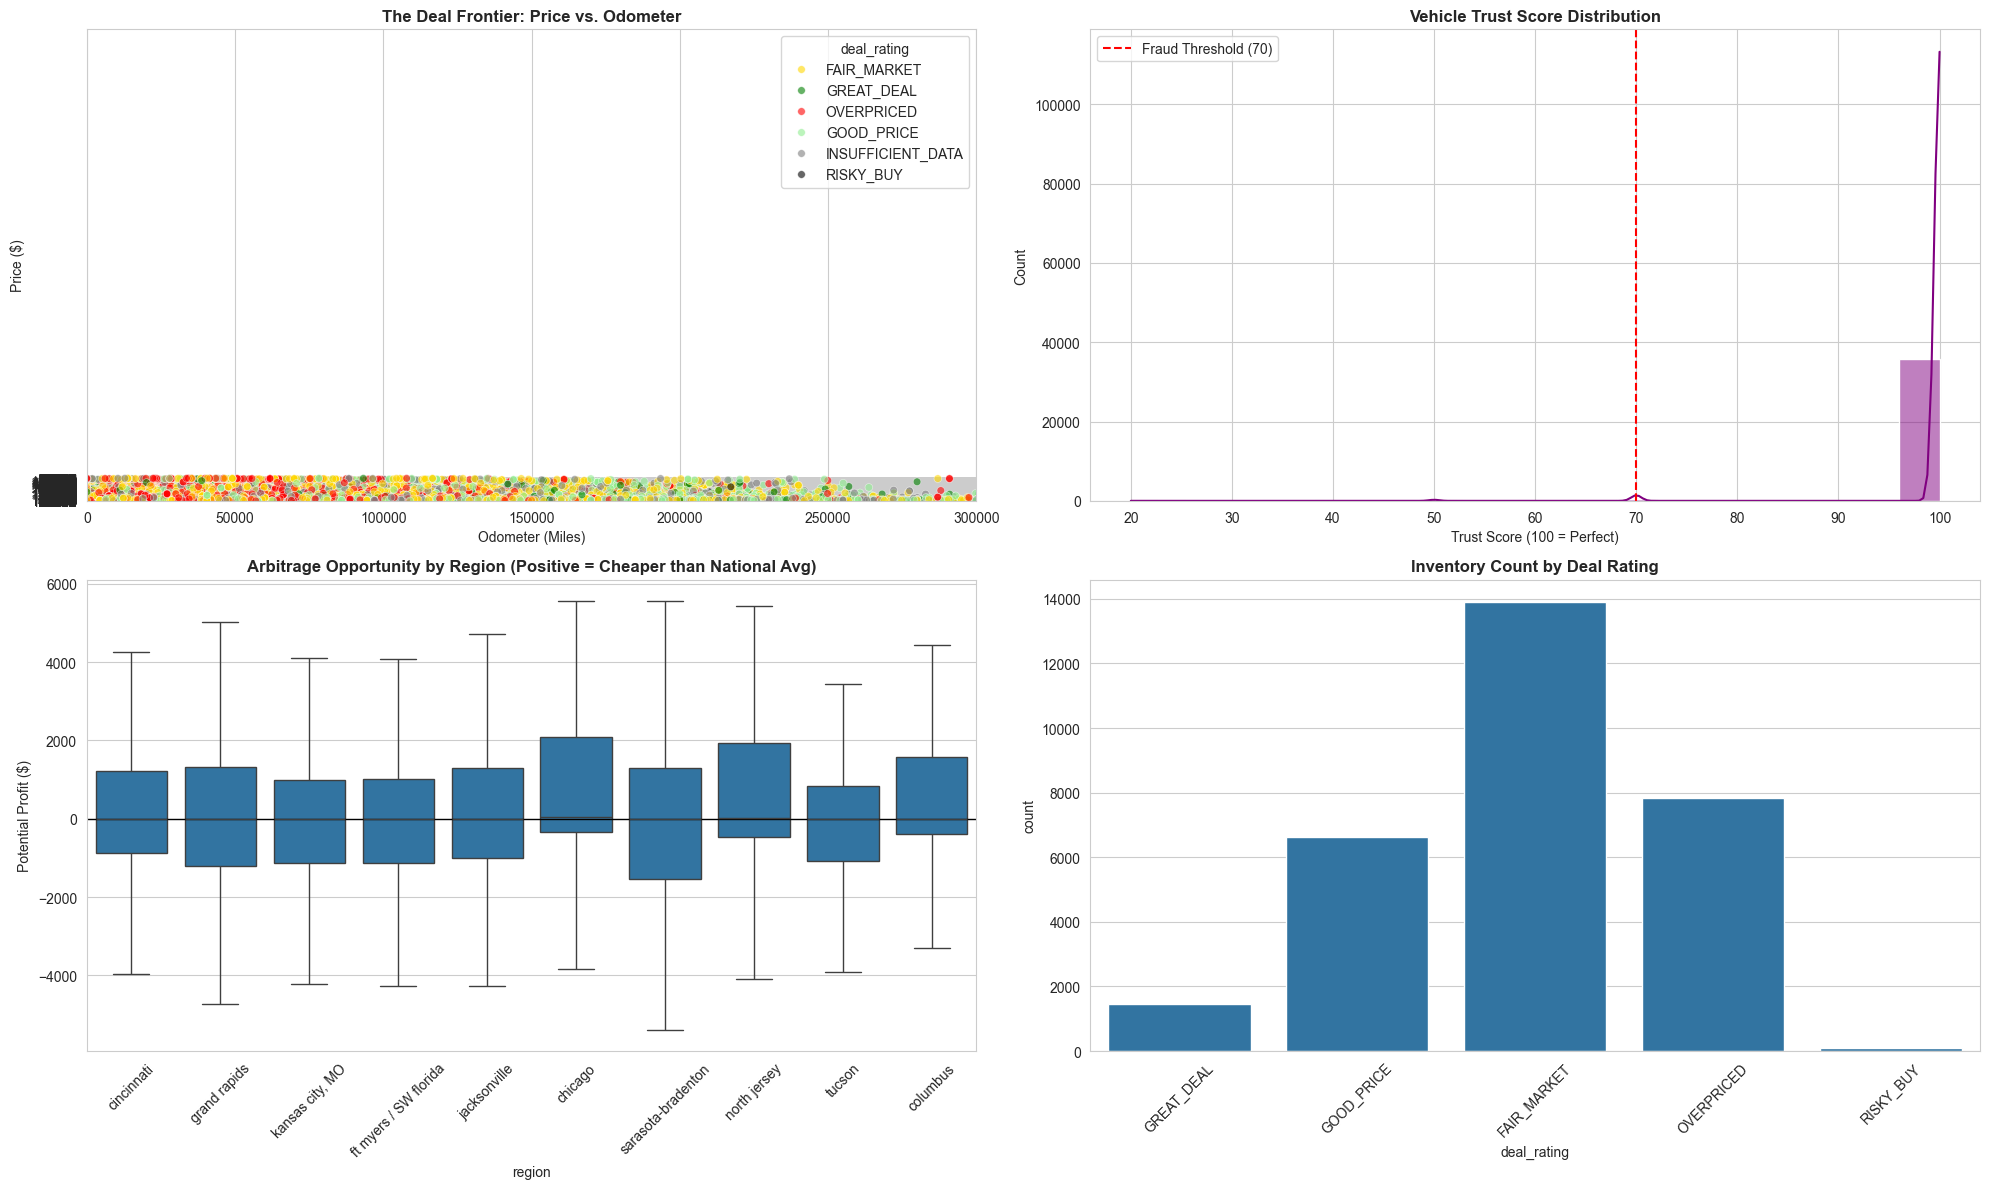

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ==========================================
# LOCAL VISUALIZATION (DEV ONLY)
# ==========================================
print("📊 Generating Local Dashboard...")

# 1. Convert to Pandas (Safety Sampling)
# We take a 10% sample to prevent crashing your laptop memory if using the 1.5GB file
# If using the small file, we take everything.
if USE_FULL_DATASET:
    print("   Sampling 10% of data for visualization...")
    viz_df = df_final.sample(fraction=0.1, seed=42).toPandas()
else:
    viz_df = df_final.toPandas()

# Set visual style
sns.set_style("whitegrid")
plt.figure(figsize=(20, 12))

# --- CHART 1: The "Deal Frontier" (Price vs. Odometer) ---
# This proves if your 'Deal Rating' logic works.
# You should see Green dots (Great Deals) at the bottom left (Low Price, Low Miles)
plt.subplot(2, 2, 1)
sns.scatterplot(data=viz_df, x='odometer', y='price', hue='deal_rating',
                palette={"GREAT_DEAL": "green", "GOOD_PRICE": "lightgreen", "FAIR_MARKET": "gold", "SLIGHTLY_HIGH": "orange", "OVERPRICED": "red", "RISKY_BUY": "black", "INSUFFICIENT_DATA": "grey"},
                alpha=0.6, s=30)
plt.title('The Deal Frontier: Price vs. Odometer', fontsize=12, fontweight='bold')
plt.xlabel('Odometer (Miles)')
plt.ylabel('Price ($)')
plt.xlim(0, 300000) # Limit x-axis to keep chart readable
plt.ylim(0, 100000)

# --- CHART 2: Fraud/Trust Score Distribution ---
# Shows how many cars are "Suspicious" (Low Trust)
plt.subplot(2, 2, 2)
sns.histplot(data=viz_df, x='trust_score', bins=20, kde=True, color='purple')
plt.axvline(x=70, color='red', linestyle='--', label='Fraud Threshold (70)')
plt.title('Vehicle Trust Score Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Trust Score (100 = Perfect)')
plt.legend()

# --- CHART 3: Arbitrage Opportunities by Region ---
# Shows which regions have the biggest price gaps vs National Average
# We filter for the top 10 regions with data
top_regions = viz_df['region'].value_counts().head(10).index
plt.subplot(2, 2, 3)
sns.boxplot(data=viz_df[viz_df['region'].isin(top_regions)], x='region', y='arbitrage_opportunity', showfliers=False)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.title('Arbitrage Opportunity by Region (Positive = Cheaper than National Avg)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Potential Profit ($)')

# --- CHART 4: Deal Rating Count ---
# Simple breakdown of inventory
plt.subplot(2, 2, 4)
sns.countplot(data=viz_df, x='deal_rating', order=["GREAT_DEAL", "GOOD_PRICE", "FAIR_MARKET", "OVERPRICED", "RISKY_BUY"])
plt.title('Inventory Count by Deal Rating', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [8]:
print("--- Step 6: Writing to BigQuery ---")

full_table_id = f"{GCP_PROJECT_ID}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME}"

try:
    # Select only valuable columns
    output_df = df_final.select(
        "id", "manufacturer", "model", "year", "price", "odometer", "region", "lat", "long",
        "vin", "trust_score", "is_year_mismatch", # Fraud features
        "national_avg_price", "arbitrage_opportunity", "is_sourcing_hub", # Geo features
        "deal_rating", # Final score
        current_timestamp().alias("processed_at")
    )

    print(f"🚀 Writing to: {full_table_id}")
    output_df.write \
        .format("bigquery") \
        .option("table", full_table_id) \
        .option("temporaryGcsBucket", GCS_TEMP_BUCKET) \
        .mode("overwrite") \
        .save()

    print("✅ SUCCESS! Market Intelligence Data is in BigQuery.")

except Exception as e:
    print("❌ ERROR writing to BigQuery.")
    print(e)

--- Step 6: Writing to BigQuery ---
🚀 Writing to: your-project-id.vehicles_data.market_intelligence_system
❌ ERROR writing to BigQuery.
An error occurred while calling o428.save.
: com.google.cloud.spark.bigquery.repackaged.com.google.inject.ProvisionException: Unable to provision, see the following errors:

1) [Guice/ErrorInCustomProvider]: IllegalArgumentException: A project ID is required for this service but could not be determined from the builder or the environment.  Please set a project ID using the builder.
  at SparkBigQueryConnectorModule.provideSparkBigQueryConfig(SparkBigQueryConnectorModule.java:100)
  while locating SparkBigQueryConfig

Learn more:
  https://github.com/google/guice/wiki/ERROR_IN_CUSTOM_PROVIDER

1 error

Full classname legend:
SparkBigQueryConfig:          "com.google.cloud.spark.bigquery.SparkBigQueryConfig"
SparkBigQueryConnectorModule: "com.google.cloud.spark.bigquery.SparkBigQueryConnectorModule"
End of classname legend:

	at com.google.cloud.spark.bi

In [10]:
import os
print("📂 Your notebook is saved here:")
print(os.getcwd())

📂 Your notebook is saved here:
C:\Users\vanac\AppData\Roaming\JetBrains\PyCharm2024.3\scratches
